# Tutorial: Ground State of 1D J1-J2 Model with RNN wavefunctions

Code by **Mohamed Hibat Allah** and **Martin Ganahl**.



**This notebook is intended to help the reader to get familiarized with Exact Diagonalization (ED) and Complex Recurrent Neural Networks (cRNN) wavefunctions. Here, we just explore small system sizes for pedagogical purposes and to keep the running time very short.**

Check if you specifying the right "path" below to the google colab notebook on Drive to make sure everything below is working properly

Make sure also you use a GPU by going to "Runtime/Change Runtime type" in Google Colaboratory to get a speedup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('gdrive/My Drive/RNNWavefunctions/RNNWavefunctions-master/J1J2')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
import tensorflow as tf
def heavyside(inputs):
    sign = tf.sign(tf.sign(inputs) + 0.1 ) #tf.sign(0) = 0, this is a way to cure that since I want tf.sign(0) = 1
    return 0.5*(sign+1.0)
with tf.Session() as sess:
    a = sess.run(heavyside(-0.1))
    print(a)

0.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['axes.labelsize']  = 20
rcParams['font.serif']      = ['Computer Modern']
rcParams['font.size']       = 10
rcParams['legend.fontsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20

## **Calculating the ground state energy of 1D J1J2 using Exact Diagonalization (ED)**

Here, we attempt to calculate the ground state and the ground state energy of the 1D J1-J2 mode with Open Boundary Conditions using Exact diagonalization.

The Hamiltonian is given as follows:

$$     \hat{H}_{J_1J_2} = J_1 \sum_{\langle i,j \rangle} \hat{{\bf S}}_i \cdot \hat{{\bf S}}_{j} + J_2 \sum_{\langle \langle i,j \rangle \rangle} \hat{{\bf S}}_i \cdot \hat{{\bf S}}_{j}.
 $$

where ${\bf S}_i$ is a spin-1/2 operator.  Here,
$\langle i,j \rangle$ and $\langle \langle i,j \rangle \rangle$ denote
nearest and next-to-nearest neighbor pairs, respectively. 

In [4]:
def J1J2MatrixElements(J1,J2,Bz,sigmap, periodic = True):

    """
    computes the matrix element of the 1D J1-J2 model for a given state sigmap
    -----------------------------------------------------------------------------------
    Parameters:
    J1, J2: np.ndarray of shape (N), respectively, and dtype=float:
                Ising parameters
    sigmap:     np.ndarrray of dtype=int and shape (N)
                spin-state, integer encoded (using 0 for down spin and 1 for up spin)
                A sample of spins can be fed here.
    Bx: Transvers magnetic field (N)
    periodic: False = open boundary conditions and True = periodic boundary conditions
    -----------------------------------------------------------------------------------            
    Returns: 2-tuple of type (np.ndarray,np.ndarray)
             sigmas:         np.ndarray of dtype=int and shape (?,N)
                             the states for which there exist non-zero matrix elements for given sigmap
             matrixelements: np.ndarray of dtype=float and shape (?)
                             the non-zero matrix elements
    """

    sigmas=[]
    matrixelements=[]
    N=len(Bz)
    #the diagonal part is simply the sum of all Sz-Sz interactions plus a B field
    diag=np.dot(sigmap-0.5,Bz)

    if periodic:
        limit = N
    else:
        limit = N-1

    for site in range(limit):
        if sigmap[site]!=sigmap[(site+1)%N]: #if the two neighouring spins are opposite
            diag-=0.25*J1[site] #add a negative energy contribution
        else:
            diag+=0.25*J1[site]
        if site<(limit-1) and J2[site] != 0.0:
            if sigmap[site]!=sigmap[(site+2)%N]: #if the two second neighouring spins are opposite
                diag-=0.25*J2[site] #add a negative energy contribution
            else:
                diag+=0.25*J2[site]
    matrixelements.append(diag) #add the diagonal part to the matrix elements
    sigmas.append(np.copy(sigmap))

    #off-diagonal part:
    for site in range(limit):
        if J1[site] != 0.0:
            if sigmap[site]!=sigmap[(site+1)%N]:
                sig=np.copy(sigmap)
                sig[site]=sig[(site+1)%N] #Make the two neighbouring spins equal.
                sig[(site+1)%N]=sigmap[site]
                sigmas.append(sig) #The last fours lines are meant to flip the two neighbouring spins (that the effect of applying J+ and J-)
                matrixelements.append(J1[site]/2)
    for site in range(limit-1):
        if J2[site] != 0.0:
            if sigmap[site]!=sigmap[(site+2)%N]:
                sig=np.copy(sigmap)
                sig[site]=sig[(site+2)%N] #Make the two neighbouring spins equal.
                sig[(site+2)%N]=sigmap[site]
                sigmas.append(sig) #The last fours lines are meant to flip the two neighbouring spins (that the effect of applying J+ and J-)
                matrixelements.append(J2[site]/2)

    return np.array(sigmas),np.array(matrixelements)


def ED_j1j2(N,j1 = 1.0,j2 =0.0, periodic=False):
    """
    Returns a tuple (eta,U)
      eta = a list of energy eigenvalues.
      U = a list of energy eigenvectors
    """
    basis = []

    #Generate a basis
    for i in range(2**N):
        basis_temp = np.zeros((N))
        a = np.array([int(d) for d in bin(i)[2:]])
        l = len(a)
        basis_temp[N-l:] = a

        basis.append(basis_temp)

    basis = np.array(basis)


    J1=j1*np.ones(N)
    J2=j2*np.ones(N)
    Bz=np.zeros(N)

    H=np.zeros((basis.shape[0],basis.shape[0])) #prepare the hamiltonian
    for n in range(basis.shape[0]):
        sigmas,elements=J1J2MatrixElements(J1,J2,Bz,np.reshape(basis[n,:],(N)),periodic) # choose one basis for calculating energy
        for m in range(sigmas.shape[0]):     # the configuration that contributes to the energy
            for b in range(basis.shape[0]):
                if np.all(basis[b,:]==sigmas[m,:]):
                    H[b,n]=elements[m]
    eta,U=np.linalg.eigh(H) #diagonalize
    return eta,U

It may take some time to do exact diagonalization. You can try up to $N=12$ spins otherwise you have to wait for a very long time.

Here we choose $J_2 = 0.2$, you are encouraged to try other values if you are curious.

In [7]:
N=14
eta,U=ED_j1j2(N, j1 = 1.0, j2=0.2, periodic = True)

print('the ground state energy is:')
E_exact = min(eta)
print(E_exact)

the ground state energy is:
-5.801060768428468


## **Representing the ground state**

Sometimes it is useful to represent the ground state in a plot as shown below, to know some information about the properties of the ground state, such as symmetries, sign of the amplitudes,...

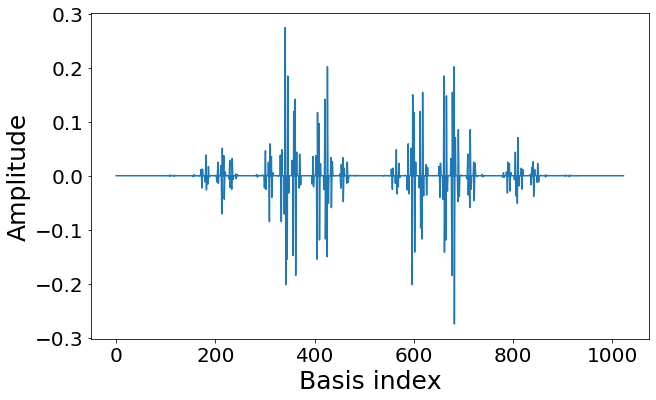

In [5]:
fig, ax = plt.subplots(figsize=(10,6))

ground_state = U[:,np.nonzero(eta==np.min(eta))[0][0]]

plt.plot(ground_state,label="Ground state")

ax.set_xlabel(r'Basis index', fontsize = 25)
ax.set_ylabel('Amplitude', fontsize = 25)

plt.show()

We notice here that the amplitudes of the ground state in the z-basis change the sign, hence we can use a complex recurrent neural network wavefunction (cRNN wavefunction) to take account of the fluctuating sign.

## **Calculating the ground state energy using an RNN wavefunction**

After that we obtained the ground state energy from exact diagonalization, we are going to value as a reference to assess the quality of the variational energy calculated by the cRNN wavefunction.

Here we choose $J_2 = 0.2$ in the same way as exact diagonalization above.

In [13]:
from TrainingRNN_J1J2 import run_J1J2

#numsteps = number of training iterations
#systemsize = the number of physical spins
#J1_, J2_ = the coupling parameters of the J1-J2 Hamiltonian
#Marshall_sign: True = A marshall sign is applied on top of the cRNN wavefunction, False = no prior is applied
#numsamples = number of samples used for training
numsamples = 250
#num_units = number of memory units of the hidden state of the RNN
#num_layers = number of vertically stacked RNN cells

#This function trains a cRNN wavefunction for 1D J1J2 with the corresponding hyperparams
RNNEnergy, varRNNEnergy = run_J1J2(numsteps = 75000, systemsize = 14, J1_  = 1.0, J2_ = 0.2, Marshall_sign = False, num_units = 50, num_layers = 3, numsamples = numsamples, learningrate = 7.5e-4, seed = 111)

#RNNEnergy is a numpy array of the variational energy of the cRNN wavefunction
#varRNNEnergy is a numpy array of the variance of the variational energy of the cRNN wavefunction

The number of variational parameters of the cRNN wavefunction is 38604


mean(E): (3.7741479873657227+0.003355169203132391j), var(E): 0.031230296939611435, #samples 250, #Step 0 


mean(E): (-1.7746469974517822+0.010428973473608494j), var(E): 3.6493825912475586, #samples 250, #Step 100 


mean(E): (-5.027778148651123-0.034004561603069305j), var(E): 0.7287822365760803, #samples 250, #Step 200 


mean(E): (-5.378227710723877+0.005534689407795668j), var(E): 0.2669663429260254, #samples 250, #Step 300 


mean(E): (-5.535992622375488+0.023010799661278725j), var(E): 0.11341043561697006, #samples 250, #Step 400 


mean(E): (-5.537049770355225-0.007936354726552963j), var(E): 0.04609627649188042, #samples 250, #Step 500 


mean(E): (-5.589578151702881-0.0017774853622540832j), var(E): 0.0399664081633091, #samples 250, #Step 600 


mean(E): (-5.580803871154785+0.0012731699971482158j), var(E): 0.021938800811767578, #samples 250, #Step 700 


mean(E): (-5.585110187530518+0.0014516732189804316j), va

mean(E): (-5.617751121520996+0.0016491232672706246j), var(E): 0.0010569224832579494, #samples 250, #Step 7300 


mean(E): (-5.614248275756836+0.0013652596389874816j), var(E): 0.0002810462028719485, #samples 250, #Step 7400 


mean(E): (-5.616710662841797+0.0003699705994222313j), var(E): 0.0009036738774739206, #samples 250, #Step 7500 


mean(E): (-5.615243434906006-0.0029444408137351274j), var(E): 0.0008987710461951792, #samples 250, #Step 7600 


mean(E): (-5.6145734786987305+0.004045895766466856j), var(E): 0.0006152109708636999, #samples 250, #Step 7700 


mean(E): (-5.614096641540527-0.0020574317313730717j), var(E): 0.000640768907032907, #samples 250, #Step 7800 


mean(E): (-5.603981018066406-0.00020717621373478323j), var(E): 0.0013191252946853638, #samples 250, #Step 7900 


mean(E): (-5.595508098602295+0.015007142908871174j), var(E): 0.01636754721403122, #samples 250, #Step 8000 


mean(E): (-5.613452911376953-0.0017893444746732712j), var(E): 0.0003272650355938822, #samples 250, 

mean(E): (-5.6152873039245605-0.0019038100726902485j), var(E): 0.0001595910725882277, #samples 250, #Step 14600 


mean(E): (-5.616340160369873-1.4490067769656889e-05j), var(E): 0.00025473927962593734, #samples 250, #Step 14700 


mean(E): (-5.6173601150512695-0.00012090098607586697j), var(E): 0.0012370438780635595, #samples 250, #Step 14800 


mean(E): (-5.615154266357422-0.0062140426598489285j), var(E): 0.0006492751417681575, #samples 250, #Step 14900 


mean(E): (-5.614694118499756-0.001634185784496367j), var(E): 0.00015612170682288706, #samples 250, #Step 15000 


mean(E): (-5.615760803222656+3.7002442695666105e-05j), var(E): 0.0001425759692210704, #samples 250, #Step 15100 


mean(E): (-5.6152849197387695-7.057494076434523e-05j), var(E): 0.0004091873415745795, #samples 250, #Step 15200 


mean(E): (-5.616499900817871+0.0014690218959003687j), var(E): 0.0005371368024498224, #samples 250, #Step 15300 


mean(E): (-5.60515832901001-0.008951503783464432j), var(E): 0.021234553307294846,

mean(E): (-5.615828990936279+0.00020714510174002498j), var(E): 0.0001052647057804279, #samples 250, #Step 21800 


mean(E): (-5.614643573760986+0.001139774569310248j), var(E): 0.00017721313633956015, #samples 250, #Step 21900 


mean(E): (-5.615281105041504+0.0019292979268357158j), var(E): 0.00014967925380915403, #samples 250, #Step 22000 


mean(E): (-5.615297317504883-0.0006008709315210581j), var(E): 0.000265008769929409, #samples 250, #Step 22100 


mean(E): (-5.613696575164795+0.0013979687355458736j), var(E): 0.0004191724583506584, #samples 250, #Step 22200 


mean(E): (-5.609070301055908+0.0045036314986646175j), var(E): 0.002015678910538554, #samples 250, #Step 22300 


mean(E): (-5.611486434936523-0.0015129615785554051j), var(E): 0.00019729608902707696, #samples 250, #Step 22400 


mean(E): (-5.615268707275391-0.0010117074707522988j), var(E): 0.0001267676125280559, #samples 250, #Step 22500 


mean(E): (-5.61572265625+0.000524996139574796j), var(E): 0.00019850267563015223, #sampl

mean(E): (-5.615767478942871+0.0023612238001078367j), var(E): 9.983259224100038e-05, #samples 250, #Step 29000 


mean(E): (-5.613561153411865-0.0008232796681113541j), var(E): 0.0002186130586778745, #samples 250, #Step 29100 


mean(E): (-5.616781234741211+0.0005359658971428871j), var(E): 9.260235674446449e-05, #samples 250, #Step 29200 


mean(E): (-5.615078926086426+0.0005704907816834748j), var(E): 0.00012429250637069345, #samples 250, #Step 29300 


mean(E): (-5.615522384643555-0.0009118628222495317j), var(E): 0.0001023740042001009, #samples 250, #Step 29400 


mean(E): (-5.615114212036133-0.00027731581940315664j), var(E): 0.00011563453881535679, #samples 250, #Step 29500 


mean(E): (-5.616598606109619-0.00023802503710612655j), var(E): 0.00010357319115428254, #samples 250, #Step 29600 


mean(E): (-5.610344886779785+0.0029760636389255524j), var(E): 0.0017841883236542344, #samples 250, #Step 29700 


mean(E): (-5.6163649559021+0.0009313372429460287j), var(E): 0.00011176747648278251,

KeyboardInterrupt: 

## **Comparison of RNN results with ED**

After we got the variational energies for each time step, we can now compare the RNN results with exact diagonalization

In [14]:
#Computing the ground state energy by taking average over the last 100 iterations
print("Ground state energy = ", np.mean(RNNEnergy[-100:]), "+-", np.sqrt(np.max(varRNNEnergy[-100:])/(numsamples*100))) #We use np.max(varRNNEnergy[-100:]) to estimate an upper bound on the error
print("Exact ground state energy = ", E_exact)

Ground state energy =  (-5.5592785-0.00094350585j) +- 0.005352263912818777
Exact ground state energy =  -5.801060768428468


Awesome! We can also plot the variational energy and the energy variance where we observe convergence during the last iterations

C:\Users\Administrator\anaconda3\envs\RNN\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


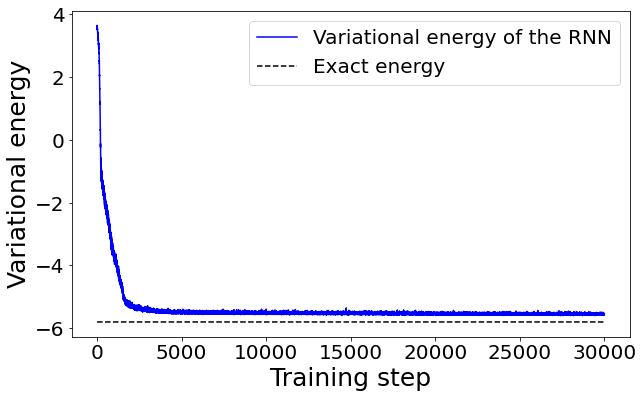

In [15]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(np.arange(1, len(RNNEnergy)+1), RNNEnergy, "b-", label="Variational energy of the RNN")
ax.plot(np.arange(1, len(RNNEnergy)+1), [E_exact]*len(RNNEnergy), "k--", label="Exact energy")

ax.set_xlabel(r'Training step', fontsize = 25)
ax.set_ylabel('Variational energy', fontsize = 25)
plt.legend()

plt.show()

### **Energy variance**

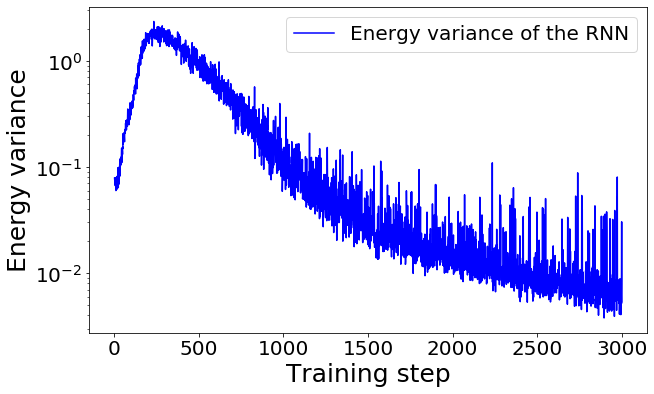

In [9]:
fig, ax = plt.subplots(figsize=(10,6))

ax.semilogy(np.arange(1, len(RNNEnergy)+1), varRNNEnergy, "b-", label="Energy variance of the RNN")

ax.set_xlabel(r'Training step', fontsize = 25)
ax.set_ylabel('Energy variance', fontsize = 25)
plt.legend()

plt.show()

In the beginning, the variance is small since the cRNN wavefunction was initially trapped in a local mimimum.

## **Explorations**

- If you want to explore large system sizes with the cRNN wavefunction, here are some ground states energy of J1-J2 model (with open boundary conditions) given by DMRG and can be considered exact:

> N = 100 (J1 = 1)
 >>  J2 = 0.0: -44.127739860

 >>  J2 = 0.2: -40.73881897

 >>  J2 = 0.5 (Majumdar-Ghosh point): -37.5

 >>  J2 = 0.8: -42.07006

- You can also play with the hyperparameters (memory units, number of layers, number of samples, learning rate, Marshall sign) to obtain better accuracies.

 